In [39]:
from visualization_tools import *
import pandas as pd
import json




In [40]:
"""
folder = "C:\\Users\\lamec\\WORK\\journal\\tensorflow"
new_folder = "C:\\Users\\lamec\\WORK\\journal\\SMX"
json_files, experiment_names, run_numbers = get_all_json_files(folder)
chunk_size = 200

chunks = [json_files[i:i + chunk_size] for i in range(0, len(json_files), chunk_size)]

combined_data = []

for i, chunk in enumerate(chunks):
    for j, file_path in enumerate(chunk):
        experiment_name = experiment_names[i * chunk_size + j]
        run_number = run_numbers[i * chunk_size + j]
        #extract_second_json(file_path, file_path.replace(folder, new_folder))
"""


'\nfolder = "C:\\Users\\lamec\\WORK\\journal\\tensorflow"\nnew_folder = "C:\\Users\\lamec\\WORK\\journal\\SMX"\njson_files, experiment_names, run_numbers = get_all_json_files(folder)\nchunk_size = 200\n\nchunks = [json_files[i:i + chunk_size] for i in range(0, len(json_files), chunk_size)]\n\ncombined_data = []\n\nfor i, chunk in enumerate(chunks):\n    for j, file_path in enumerate(chunk):\n        experiment_name = experiment_names[i * chunk_size + j]\n        run_number = run_numbers[i * chunk_size + j]\n        #extract_second_json(file_path, file_path.replace(folder, new_folder))\n'

In [41]:
run_number = range(1, 33)
#task = "tensorflow"
folder = "C:\\Users\\lamec\\WORK\\journal\\dumps"
folder = "/Users/soren/Work/journal/fmnist_only_attempts"
# Create the DataFrame with specified columns and data types
df = pd.DataFrame({
    'Experiment name': pd.Series(dtype='string'),
    'Run number': pd.Series(dtype='string'),
    'Individual number': pd.Series(dtype='int64'),
    'Phenotype': pd.Series(dtype='string'),
    'Smart Phenotype': pd.Series(dtype='string'),
    'Fitness': pd.Series(dtype='float64')
})


df = load_results(folder)



/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_2/iteration_1.json 1
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_2/iteration_0.json 0
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_2/iteration_3.json 3
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_2/iteration_2.json 2
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_51.json 51
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_10.json 10
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_47.json 47
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_30.json 30
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_26.json 26
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_7.json 7
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_6.json 6
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_27.json 27
/Users/soren/Work/journal/fmnist

/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_34.json 34
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_43.json 43
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_14.json 14
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_38.json 38
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_39.json 39
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_15.json 15
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_42.json 42
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_35.json 35
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_23.json 23
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_2.json 2
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_19.json 19
/Users/soren/Work/journal/fmnist_only_attempts/FMNIST/run_10/iteration_45.json 45
/Users/soren/Work/

In [42]:
df

,Experiment name,Run number,Individual number,Generation,Phenotype,Smart Phenotype,Fitness
0,FMNIST,run_2,22,1,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(multiply(sqrt(grad), multiply(beta, g...",-0.11466
1,FMNIST,run_2,28,1,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(subtract(layer_count, layer_count), g...",-0.11466
2,FMNIST,run_2,29,1,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(multiply(divide_no_nan(grad, constant...",-0.11466
3,FMNIST,run_2,35,1,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(subtract(constant(0.0), multiply(mult...",-0.11466
4,FMNIST,run_2,26,1,"alpha_func, beta_func, sigma_func, grad_func =...","divide_no_nan(grad, add(constant(0.1), grad))",-0.10000
...,...,...,...,...,...,...,...
8575,FMNIST,run_7,200,44,"alpha_func, beta_func, sigma_func, grad_func =...","negative(multiply(grad, square(constant(1.0))))",-0.10000
8576,FMNIST,run_7,243,44,"alpha_func, beta_func, sigma_func, grad_func =...","negative(multiply(grad, negative(constant(0.01...",-0.10000
8577,FMNIST,run_7,172,44,"alpha_func, beta_func, sigma_func, grad_func =...","negative(multiply(grad, square(constant(0.1))))",-0.10000
8578,FMNIST,run_7,45,44,"alpha_func, beta_func, sigma_func, grad_func =...",layer_count,0.00000


In [43]:
 # Assuming you already have the DataFrame, let's call it 'df'

# Group by 'Experiment name' and 'Run number', then count the entries in each group
individual_counts = df.groupby(['Experiment name', 'Run number'])['Individual number'].nunique().reset_index(name='Unique Individual Count')
df['Fitness'] = df['Fitness'] * -1
individual_counts
df.head(5)

,Experiment name,Run number,Individual number,Generation,Phenotype,Smart Phenotype,Fitness
0,FMNIST,run_2,22,1,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(multiply(sqrt(grad), multiply(beta, g...",0.11466
1,FMNIST,run_2,28,1,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(subtract(layer_count, layer_count), g...",0.11466
2,FMNIST,run_2,29,1,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(multiply(divide_no_nan(grad, constant...",0.11466
3,FMNIST,run_2,35,1,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(subtract(constant(0.0), multiply(mult...",0.11466
4,FMNIST,run_2,26,1,"alpha_func, beta_func, sigma_func, grad_func =...","divide_no_nan(grad, add(constant(0.1), grad))",0.10000


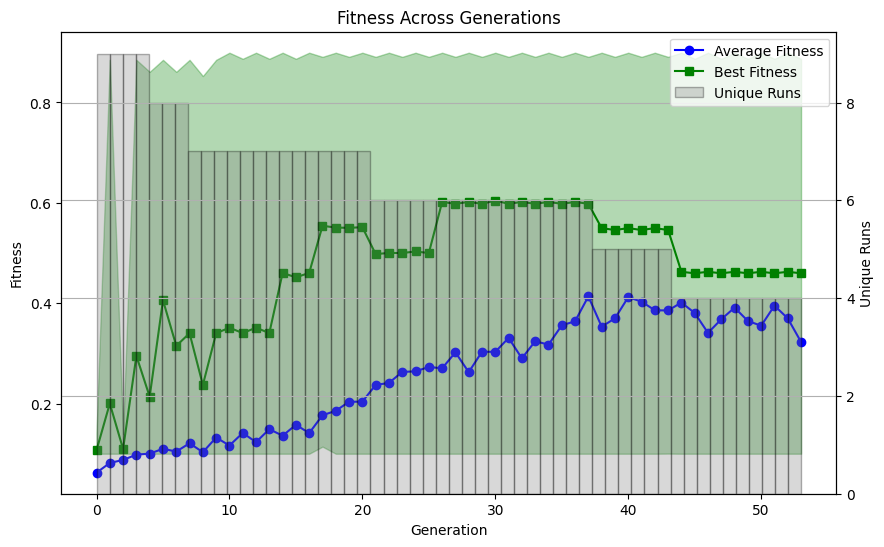

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns 'Generation', 'Fitness', 'Experiment name', and 'Run number'

# Step 1: Group by 'Experiment name', 'Run number', and 'Generation', and compute the mean and max fitness for each group
fitness_data = df.groupby(['Experiment name', 'Run number', 'Generation'])['Fitness'].agg(['mean', 'max']).reset_index()

# Step 2: Group by 'Generation' and compute the overall mean and max fitness for each generation
generation_stats = fitness_data.groupby('Generation').agg({'mean': 'mean', 'max': 'mean', 'Run number': 'nunique'}).reset_index()
generation_stats.rename(columns={'Run number': 'Unique Runs'}, inplace=True)

# Step 3: Calculate highest and lowest fitness across all runs per generation from the max fitness data
highest_fitness = fitness_data.groupby('Generation')['max'].max().reset_index()
lowest_fitness = fitness_data.groupby('Generation')['max'].min().reset_index()

# Step 4: Plot the average fitness, best fitness, and the shadow for the range between highest and lowest fitness
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average fitness on the first y-axis
ax1.plot(generation_stats['Generation'], generation_stats['mean'], marker='o', linestyle='-', color='b', label='Average Fitness')
ax1.plot(generation_stats['Generation'], generation_stats['max'], marker='s', linestyle='-', color='g', label='Best Fitness')
ax1.fill_between(generation_stats['Generation'], lowest_fitness['max'], highest_fitness['max'], alpha=0.3, color='g')

ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness')
ax1.set_title('Fitness Across Generations')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot transparent histogram for unique runs on the secondary y-axis
ax2.hist(generation_stats['Generation'], bins=len(generation_stats), alpha=0.3, color='gray', edgecolor='black',
         weights=generation_stats['Unique Runs'], label='Unique Runs')
ax2.set_ylabel('Unique Runs')

# Combine the legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

plt.grid(True)
plt.show()


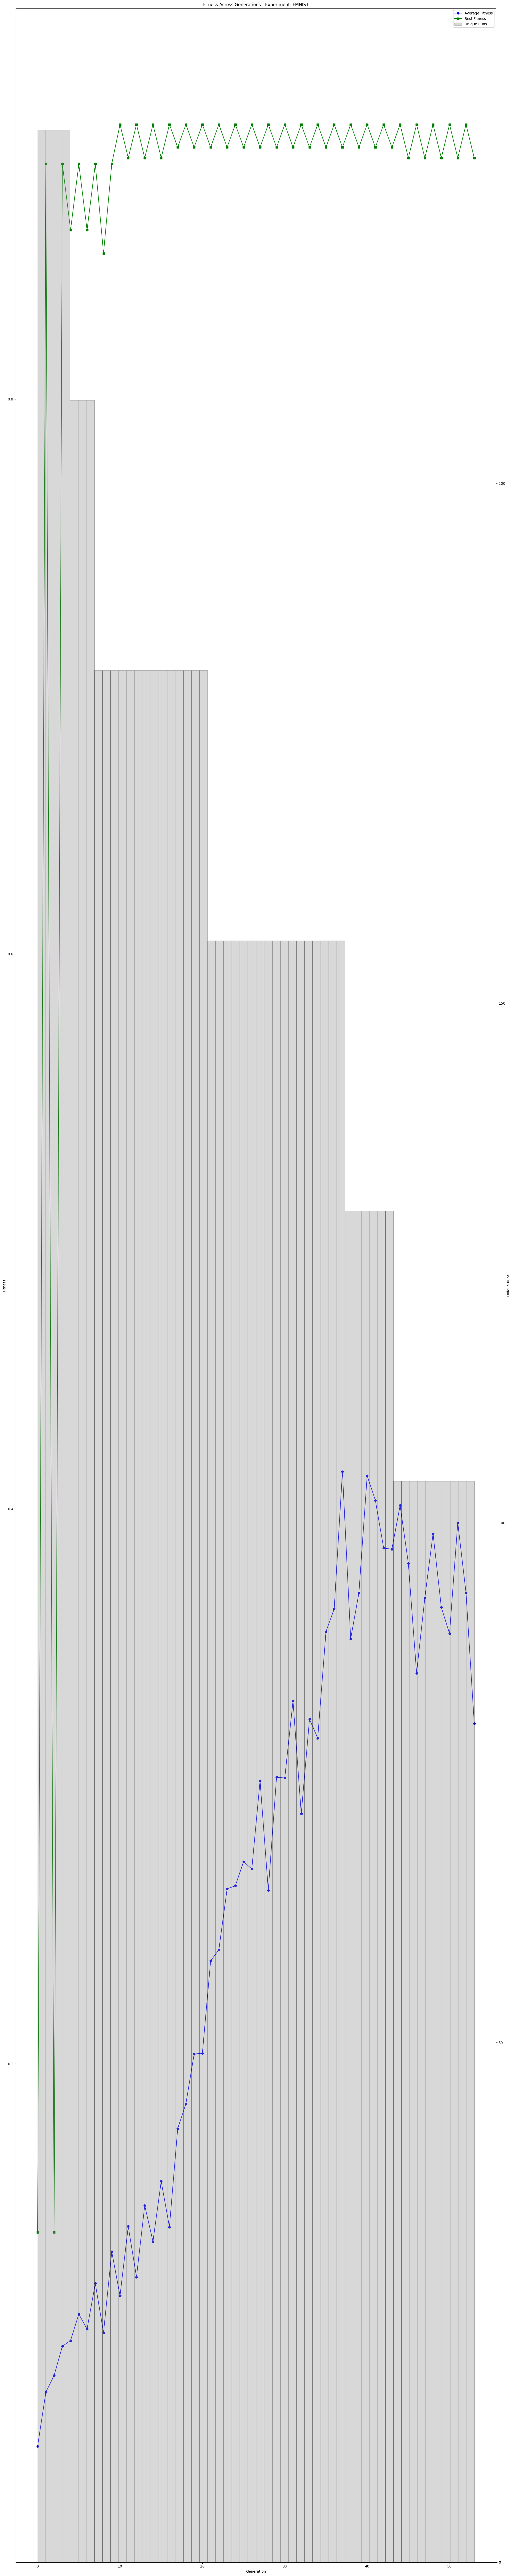

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib.rcParams["pdf.fonttype"] = 42
#matplotlib.rcParams["ps.fonttype"] = 42
#plt.rcParams["figure.figsize"] = [20, 100]

# Assuming you have a DataFrame 'df' with columns 'Generation', 'Fitness', 'Experiment name', and 'Run number'

# Step 1: Group by 'Experiment name', 'Run number', and 'Generation', and compute the mean and max fitness for each group
#fitness_data = df.groupby(['Experiment name', 'Run number', 'Generation'])['Fitness'].agg(['mean', 'max']).reset_index()

# Step 2: Group by 'Generation' and compute the overall mean and max fitness for each generation
#generation_stats = fitness_data.groupby(['Experiment name', 'Generation']).agg({'mean': 'mean', 'max': 'mean', 'Run number': 'nunique'}).reset_index()
#generation_stats.rename(columns={'Run number': 'Unique Runs'}, inplace=True)

# Step 3: Calculate highest and lowest fitness across all runs per generation from the max fitness data
#highest_fitness = fitness_data.groupby(['Experiment name', 'Generation'])['max'].max().reset_index()
#lowest_fitness = fitness_data.groupby(['Experiment name', 'Generation'])['max'].min().reset_index()

# Step 4: Create subplots for each experiment with a shared y-axis
experiment_names = df['Experiment name'].unique()
if len(experiment_names) < 1:
    fig, axs = plt.subplots(len(experiment_names), figsize=(20, 20), sharey=True)  # sharey=True ensures shared y-axis

    for i, experiment_name in enumerate(experiment_names):
        df_i = df[df['Experiment name'] == experiment_name]
        ax = axs[i]

        mean_fitness_generation = df_i.groupby(['Generation']).agg({'Fitness': 'mean'}).reset_index()
        max_fitness_generation = df_i.groupby(['Generation']).agg({'Fitness': 'max'}).reset_index()
        count_runs_generation = df_i.groupby(['Generation']).agg({'Run number': 'count'}).reset_index()
        # Plot average fitness on the first y-axis
        ax.plot(mean_fitness_generation['Generation'], mean_fitness_generation['Fitness'], marker='o', linestyle='-', color='b', label='Average Fitness')
        ax.plot(max_fitness_generation['Generation'], max_fitness_generation['Fitness'], marker='s', linestyle='-', color='g', label='Best Fitness')
        #ax.fill_between(experiment_data['Generation'], experiment_lowest['max'], experiment_highest['max'], alpha=0.3, color='g')
        
        ax.set_xlabel('Generation')
        ax.set_ylabel('Fitness')
        ax.set_title(f'Fitness Across Generations - Experiment: {experiment_name}')
        
        # Create a secondary y-axis for the histogram
        ax2 = ax.twinx()
        
        # Plot transparent histogram for unique runs on the secondary y-axis
        ax2.hist(count_runs_generation['Generation'], bins=len(count_runs_generation), alpha=0.3, color='gray', edgecolor='black',
                weights=count_runs_generation['Run number'], label='Unique Runs')
        ax2.set_ylabel('Unique Runs')
        
        # Combine the legends from both y-axes
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2)

    plt.tight_layout()
    plt.show()
else:
    experiment_name = experiment_names[0]
    df_i = df[df['Experiment name'] == experiment_name]
    ax = plt.gca()

    mean_fitness_generation = df_i.groupby(['Generation']).agg({'Fitness': 'mean'}).reset_index()
    max_fitness_generation = df_i.groupby(['Generation']).agg({'Fitness': 'max'}).reset_index()
    count_runs_generation = df_i.groupby(['Generation']).agg({'Run number': 'count'}).reset_index()
    # Plot average fitness on the first y-axis
    ax.plot(mean_fitness_generation['Generation'], mean_fitness_generation['Fitness'], marker='o', linestyle='-', color='b', label='Average Fitness')
    ax.plot(max_fitness_generation['Generation'], max_fitness_generation['Fitness'], marker='s', linestyle='-', color='g', label='Best Fitness')
    #ax.fill_between(experiment_data['Generation'], experiment_lowest['max'], experiment_highest['max'], alpha=0.3, color='g')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Fitness Across Generations - Experiment: {experiment_name}')
    
    # Create a secondary y-axis for the histogram
    ax2 = ax.twinx()
    
    # Plot transparent histogram for unique runs on the secondary y-axis
    ax2.hist(count_runs_generation['Generation'], bins=len(count_runs_generation), alpha=0.3, color='gray', edgecolor='black',
            weights=count_runs_generation['Run number'], label='Unique Runs')
    ax2.set_ylabel('Unique Runs')
    
    # Combine the legends from both y-axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)

    plt.tight_layout()
    plt.show()

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



df_mean_fitness = df.groupby(['Experiment name', 'Run number']).agg({'Generation': 'max'}).reset_index()

last_gen_stats = {'Experiment name': [], "Fitness": [], "Generation": []}
for i, data in df_mean_fitness.iterrows():
    #print(data)
    last_gen_stats['Experiment name'].append(data['Experiment name'])
    last_gen_stats['Fitness'].append(np.mean(df[(df['Generation'] == data['Generation']) & (df['Experiment name'] == data['Experiment name']) & (df['Run number'] == data['Run number'])]['Fitness']))
    last_gen_stats['Generation'].append(data['Generation'])

df_mean_fitness = pd.DataFrame(last_gen_stats)

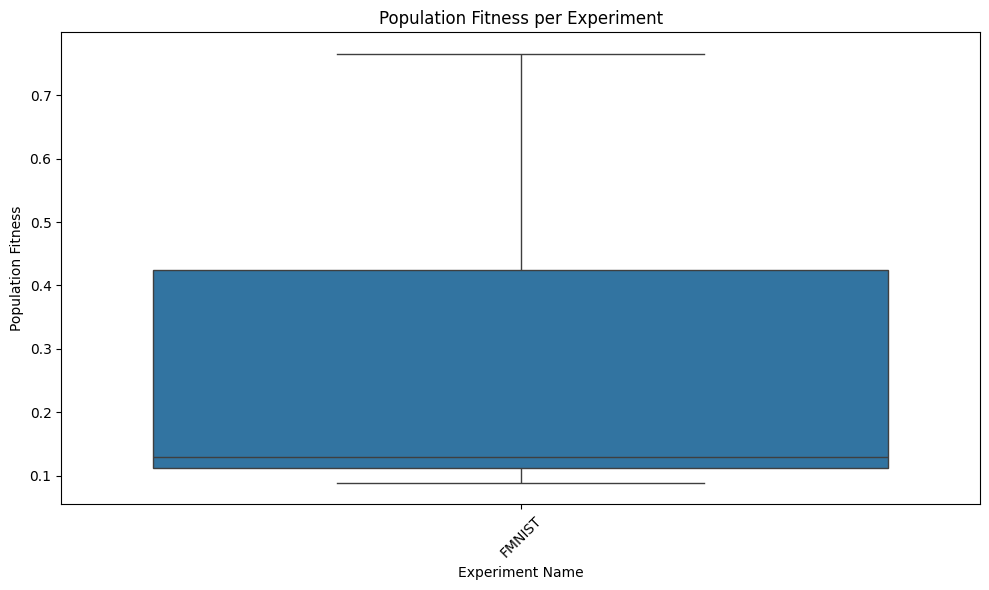

Experiment: FMNIST 0.2898289814782448


In [47]:

# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_mean_fitness, x='Experiment name', y='Fitness')

# Customize the plot
plt.title('Population Fitness per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Population Fitness')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
#plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
for i, experiment_name in enumerate(experiment_names):
    df_i = df_mean_fitness[df_mean_fitness['Experiment name'] == experiment_name]
    print(f"Experiment: {experiment_name} {np.mean(df_i['Fitness'])}")


  Experiment name Run number   Fitness
0          FMNIST      run_0  0.862887
1          FMNIST      run_1  0.877340
2          FMNIST     run_10  0.128660
3          FMNIST     run_11  0.897472
4          FMNIST      run_2  0.114660


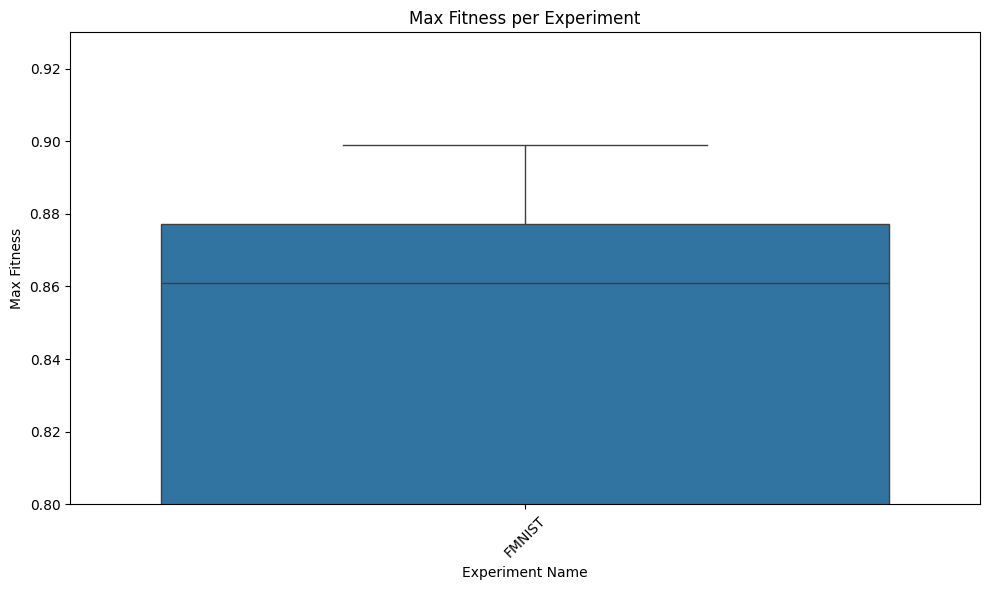

Experiment: FMNIST Mean: 0.6133354264828894 Max: 0.8989999890327454


In [48]:


# Assuming you have a DataFrame 'df' with columns 'Experiment name', 'Run number', and 'Fitness'
df_max_fitness = df.groupby(['Experiment name', 'Run number']).agg({'Fitness': 'max'}).reset_index()
print(df_max_fitness.head(5))
# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_max_fitness, x='Experiment name', y='Fitness')

# Customize the plot
plt.title('Max Fitness per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Max Fitness')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
for i, experiment_name in enumerate(experiment_names):
    df_i = df_max_fitness[df_max_fitness['Experiment name'] == experiment_name]
    print(f"Experiment: {experiment_name} Mean: {np.mean(df_i['Fitness'])} Max: {np.max(df_i['Fitness'])}")


  Experiment name Run number  Smart Phenotype
0          FMNIST      run_0               12
1          FMNIST      run_1                5
2          FMNIST     run_10                1
3          FMNIST     run_11               71
4          FMNIST      run_2               14


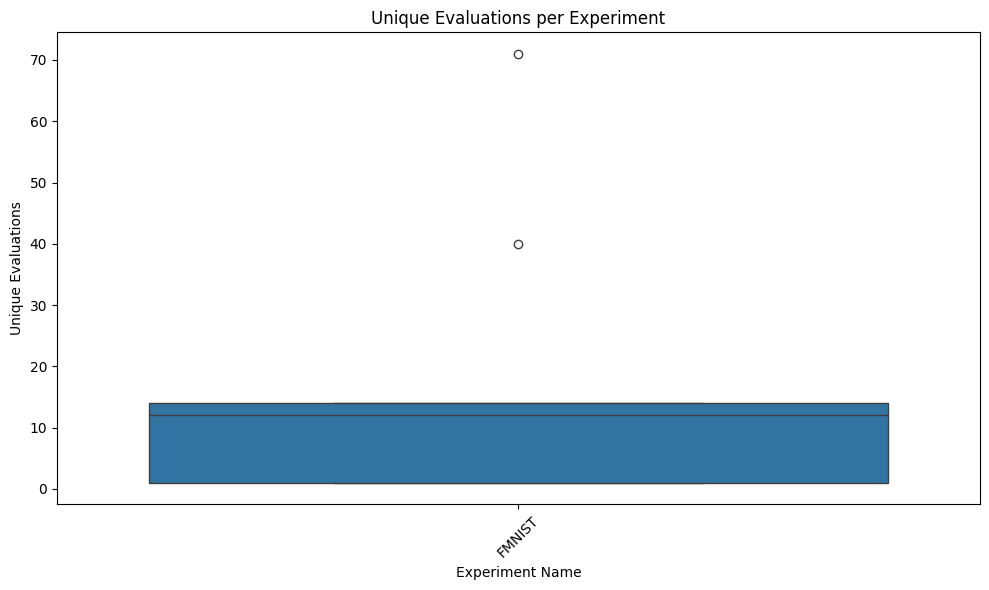

In [49]:
# Assuming you have a DataFrame 'df' with columns 'Experiment name', 'Run number', and 'Fitness'
df_unique_evals = df[df['Fitness'] >= 0.11].groupby(['Experiment name', 'Run number']).agg({'Smart Phenotype': 'nunique'}).reset_index()
print(df_unique_evals.head(5))
# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_unique_evals, x='Experiment name', y='Smart Phenotype')

# Customize the plot
plt.title('Unique Evaluations per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Unique Evaluations')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
#plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
#for i, experiment_name in enumerate(experiment_names):
    #df_i = df_max_fitness[df_max_fitness['Experiment name'] == experiment_name]
    #print(f"{experiment_name} {np.mean(df_i['Fitness'])}")


  Experiment name Run number  Smart Phenotype
0          FMNIST      run_0               11
1          FMNIST      run_1                4
2          FMNIST     run_11               32
3          FMNIST      run_6                1
4          FMNIST      run_7                3


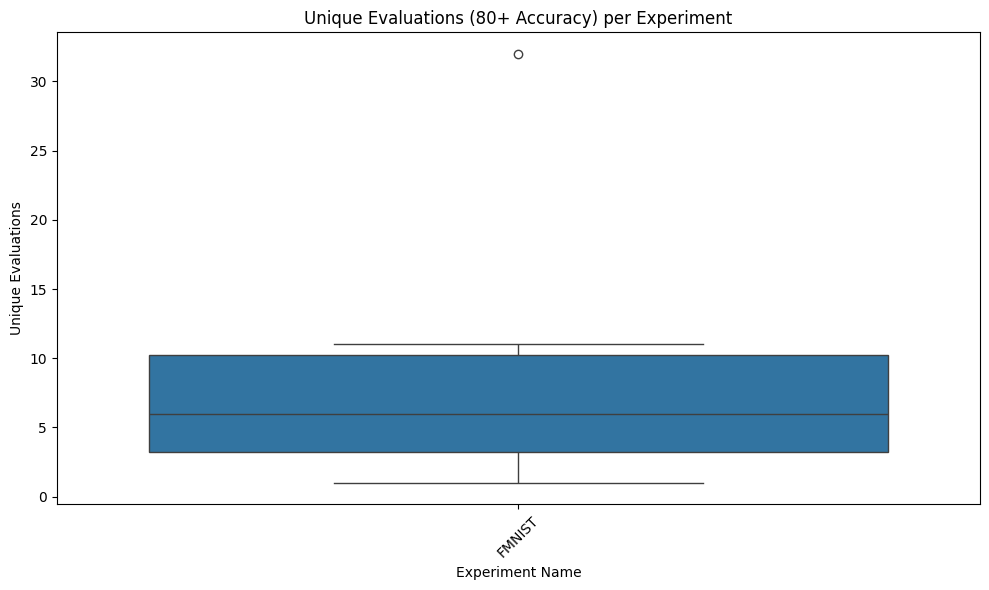

FMNIST 9.833333333333334


In [50]:
# Assuming you have a DataFrame 'df' with columns 'Experiment name', 'Run number', and 'Fitness'
df_unique_evals = df[df['Fitness'] >= 0.5].groupby(['Experiment name', 'Run number']).agg({'Smart Phenotype': 'nunique'}).reset_index()
print(df_unique_evals.head(5))
# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_unique_evals, x='Experiment name', y='Smart Phenotype')

# Customize the plot
plt.title('Unique Evaluations (80+ Accuracy) per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Unique Evaluations')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
#plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
for i, experiment_name in enumerate(experiment_names):
    df_i = df_unique_evals[df_unique_evals['Experiment name'] == experiment_name]
    print(f"{experiment_name} {np.mean(df_i['Smart Phenotype'])}")

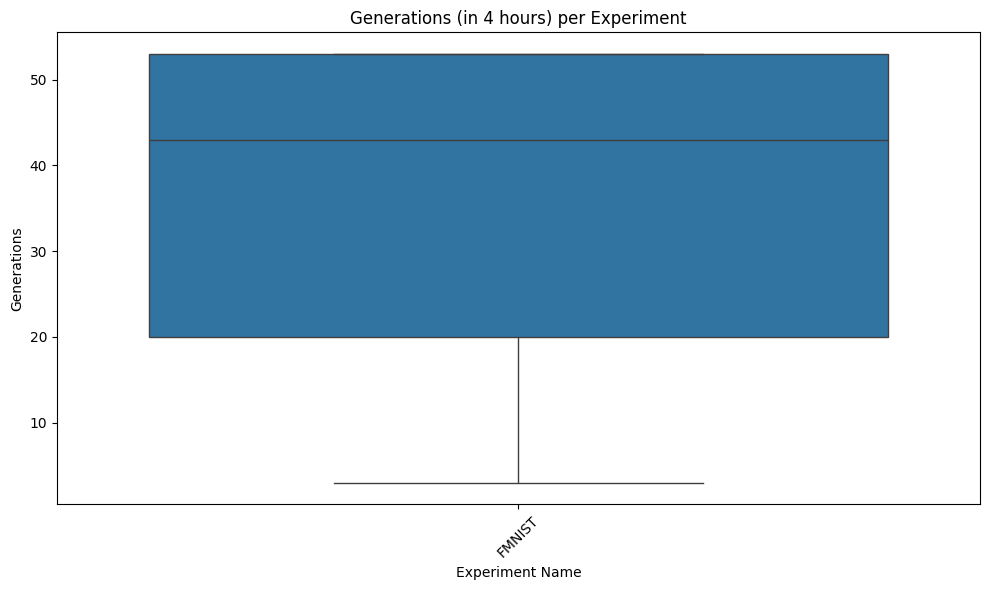

/var/folders/ty/mww5pldj4jv73m00vfvl0dyw0000gn/T/ipykernel_42545/4284434304.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_i = df_mean_fitness[df_unique_evals['Experiment name'] == experiment_name]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [51]:
# Step 1: Create a box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use seaborn to create a box plot, specifying 'x' as 'Experiment name' and 'y' as 'Fitness'
sns.boxplot(data=df_mean_fitness, x='Experiment name', y='Generation')

# Customize the plot
plt.title('Generations (in 4 hours) per Experiment')
plt.xlabel('Experiment Name')
plt.ylabel('Generations')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
#plt.tight_layout()
#plt.show()

# Set custom y-axis limits (adjust these values as needed)
#plt.ylim(0.8, 0.93)  # Example: set the y-axis limits from 0 to 100

# Show the plot
plt.tight_layout()
plt.show()
for i, experiment_name in enumerate(experiment_names):
    df_i = df_mean_fitness[df_unique_evals['Experiment name'] == experiment_name]
    print(f"{experiment_name} {np.mean(df_i['Generation'])}")

In [58]:
print(df['Run number'].unique())
df.sort_values('Fitness', ascending=False)[['Smart Phenotype', 'Phenotype', 'Fitness']].to_csv('interesting_indivs.csv')


['run_2' 'run_10' 'run_11' 'run_6' 'run_1' 'run_8' 'run_9' 'run_0' 'run_7']
